# Market Segmentation of Spotify Artists

A clustering problem is where you want to discover the inherent groupings in the data without knowing what the actual classes are.


   
   
Goal is to group objects into similar classes so that:
- intra-class similarity(distance) is high
- inter-class similarity(distance) is low

Hierarchical Clustering
- Agglomerative: starts with n clusters, then combines two most similar clusters, combines next two most similar clusters, and so on
- Divisive: opposite of agglomerative, goes from 1 to n clusters

Non-Hierarchical Clustering: choosing k initial clusters and reassign observations until no improvement can be obtained

K-Means
1. Randomly assign a number from, 1 to K, to each of the observations. These serve as initial cluster assignments for the observations.
2. Iterate until the cluster assignments stop changing:
   - For each of the K clusters, compute the cluster centroid. The kth cluster centroid is the vector of the p feature means for the observations in the kth cluster.
   - Assign each observation to the cluster whose centroid is closest (where closest is defined using Euclidean distance.)
- Assumption 1: cluster center = arithmetic mean of all points belonging to the cluster; each cluster center is recalculated in the beginning of each new iteration
- Assumption 2: after cluster center has been recalculated, if given point is now closer to a different cluster center, then it is reassigned to the closer center



try cos distance

## Set-Up

### Import Libraries

In [65]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 40)
pd.set_option('display.width', 1000)

### Import Data

In [2]:
# Read CSV to DataFrame
artists = pd.read_csv('Data/artists_train.csv')

# Drop unnamed column
artists.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)

# Preview dataframe
print(artists.info())
artists.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194248 entries, 0 to 194247
Data columns (total 28 columns):
artist_id                  194248 non-null object
artist_name                191716 non-null object
artist_followers           194248 non-null float64
artist_popularity          194248 non-null float64
track_popularity_mean      194248 non-null float64
track_popularity_std       194248 non-null float64
track_release_year_mean    194248 non-null float64
track_release_year_std     194248 non-null float64
acousticness_mean          194248 non-null float64
acousticness_std           194248 non-null float64
danceability_mean          194248 non-null float64
danceability_std           194248 non-null float64
duration_ms_mean           194248 non-null float64
duration_ms_std            194248 non-null float64
energy_mean                194248 non-null float64
energy_std                 194248 non-null float64
instrumentalness_mean      194248 non-null float64
instrumentalness_std    

,artist_id,artist_name,artist_followers,artist_popularity,track_popularity_mean,track_popularity_std,track_release_year_mean,track_release_year_std,acousticness_mean,acousticness_std,danceability_mean,danceability_std,duration_ms_mean,duration_ms_std,energy_mean,energy_std,instrumentalness_mean,instrumentalness_std,liveness_mean,liveness_std,loudness_mean,loudness_std,speechiness_mean,speechiness_std,tempo_mean,tempo_std,valence_mean,valence_std
0,2jTsRGHAvKXXSbeO52G1t5,Webbstur,3453.0,28.0,17.8,10.195860,2017.3,0.948683,0.170563,0.255500,0.5925,0.116009,245121.3,51594.498027,0.84040,0.086234,0.413950,0.373703,0.15339,0.093559,-6.7449,1.570696,0.04442,0.015108,124.9970,2.174399,0.42026,0.266024
1,5CRw2KQzb9aH8HuyuQ6QCL,Ozy,103.0,6.0,2.5,5.233439,2012.7,4.001389,0.197861,0.354064,0.6189,0.177373,267232.6,94528.177818,0.72450,0.278383,0.672460,0.294077,0.21175,0.136774,-9.2551,5.195449,0.09468,0.055908,148.4241,21.335355,0.44111,0.272943
2,11fxyJpCpCnuG2c6NMuZNt,Bia Macedo,5177.0,11.0,7.8,4.391912,2017.0,0.000000,0.262620,0.159743,0.6322,0.087031,180036.6,12755.167904,0.87670,0.123941,0.000000,0.000000,0.37700,0.226577,-2.9268,2.288700,0.12018,0.090222,153.8066,20.089296,0.77540,0.090969
3,0pRBqfB42iVqXKIFJdfFKS,Brett Detar,1781.0,20.0,14.1,7.752419,2011.8,1.549193,0.183107,0.270250,0.4248,0.128387,259215.9,49391.796063,0.66320,0.200920,0.072125,0.140028,0.22184,0.176418,-7.4456,2.286342,0.03678,0.017357,135.1359,29.490275,0.48690,0.269610
4,5MpELOfAiq7aIBTij30phD,Harry James,17750.5,53.0,34.7,9.894709,1977.8,31.701901,0.841900,0.158289,0.4435,0.140408,197270.7,38825.948564,0.24639,0.198372,0.267144,0.373276,0.18035,0.086693,-12.8619,4.617813,0.03994,0.018269,100.5924,21.342652,0.40420,0.173864


### Define X

In [3]:
X_train = artists.drop(columns=['artist_id', 'artist_name'])

### Normalize Data

**Standard Scaler**

In [4]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_sscaled = ss.fit_transform(X_train)
X_train_sscaled = pd.DataFrame(X_train_sscaled, columns=X_train.columns)

**MinMax Scaler**

In [5]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_mmscaled = mms.fit_transform(X_train)
X_train_mmscaled = pd.DataFrame(X_train_mmscaled, columns=X_train.columns)

## K-Means Baseline

### Standard Scaler vs MinMax Scaler

In [6]:
# Using Data Normalized with Standard Scaler
# Fitting K-Means Model for 2-11 Clusters

from sklearn.cluster import KMeans 
from sklearn import metrics
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score

km_scores_ss = []
calinski_scores_ss = []
silhouette_scores_ss = []
davies_scores_ss = []
for i in range(2,12):
    print("-", i, 'Clusters')
    km = KMeans(n_clusters=i, random_state=0, n_jobs=-2).fit(X_train_sscaled)
    preds = km.predict(X_train_sscaled)
    
    km_score = km.score(X_train_sscaled)
    km_scores_ss.append(km_score)
    print("K-Means Score:", km_score)
    
    calinski = calinski_harabasz_score(X_train_sscaled,preds)
    calinski_scores_ss.append(calinski)
    print("Calinski Harabasz Score:", calinski)

    silhouette = silhouette_score(X_train_sscaled,preds)
    silhouette_scores_ss.append(silhouette)
    print("Silhouette Score:", silhouette)
    
    db = davies_bouldin_score(X_train_sscaled,preds)
    davies_scores_ss.append(db)
    print("Davies Bouldin Score:", db)
    
    print("-"*45)

K-Means Score for 2 clusters: -4465064.421766379
Calinski Harabasz score for 2 clusters: 25466.299856159963
Silhouette score for 2 clusters: 0.17723906425340444
Davies Bouldin score for 2 clusters: 2.3083947617637053
-----------------------------------------------------------------
K-Means Score for 3 clusters: -4094237.8304623067
Calinski Harabasz score for 3 clusters: 22683.00742285639
Silhouette score for 3 clusters: 0.12729827904766866
Davies Bouldin score for 3 clusters: 2.265289792581527
-----------------------------------------------------------------
K-Means Score for 4 clusters: -3826240.8850751766
Calinski Harabasz score for 4 clusters: 20716.15002819284
Silhouette score for 4 clusters: 0.11120942343189566
Davies Bouldin score for 4 clusters: 2.287302978472165
-----------------------------------------------------------------
K-Means Score for 5 clusters: -3658732.9783131694
Calinski Harabasz score for 5 clusters: 18471.626830551482
Silhouette score for 5 clusters: 0.101571548

In [11]:
# Using Data Normalized with MinMax Scaler
# Fitting K-Means Model for 2-11 Clusters

from sklearn.cluster import KMeans 
from sklearn import metrics
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score

km_scores_mms = []
calinski_scores_mms = []
silhouette_scores_mms = []
davies_scores_mms = []
for i in range(2,12):
    print("-", i, 'Clusters')
    km = KMeans(n_clusters=i, random_state=0, n_jobs=-2).fit(X_train_mmscaled)
    preds = km.predict(X_train_mmscaled)
    
    km_score = km.score(X_train_mmscaled)
    km_scores_mms.append(km_score)
    print("K-Means Score:", km_score)
    
    calinski = calinski_harabasz_score(X_train_mmscaled,preds)
    calinski_scores_mms.append(calinski)
    print("Calinski Harabasz Score:", calinski)

    silhouette = silhouette_score(X_train_mmscaled,preds)
    silhouette_scores_mms.append(silhouette)
    print("Silhouette Score:", silhouette)
    
    db = davies_bouldin_score(X_train_mmscaled,preds)
    davies_scores_mms.append(db)
    print("Davies Bouldin Score:", db)
    
    print("-"*45)

K-Means Score for 2 clusters: -86264.98320993343
Calinski Harabasz score for 2 clusters: 58037.16615967248
Silhouette score for 2 clusters: 0.2589095995488793
Davies Bouldin score for 2 clusters: 1.6143821196442054
-----------------------------------------------------------------
K-Means Score for 3 clusters: -72924.5217040235
Calinski Harabasz score for 3 clusters: 52094.04786468934
Silhouette score for 3 clusters: 0.21253858991563226
Davies Bouldin score for 3 clusters: 1.6432287421260405
-----------------------------------------------------------------
K-Means Score for 4 clusters: -66518.14092147734
Calinski Harabasz score for 4 clusters: 44309.882453166094
Silhouette score for 4 clusters: 0.18631155048634743
Davies Bouldin score for 4 clusters: 1.7583643375872549
-----------------------------------------------------------------
K-Means Score for 5 clusters: -62233.58790842209
Calinski Harabasz score for 5 clusters: 38863.37561252006
Silhouette score for 5 clusters: 0.1518439412900

### Evaluate Scores to Find Best K

**K-Means Score**

The k-means score is an indication of how far the points are from the centroids. In scikit learn, the score is better the closer to zero it is. Bad scores will return a large negative number, whereas good scores return close to zero.

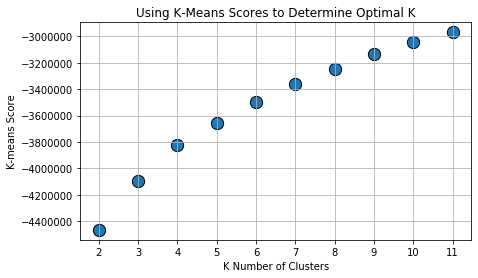

In [7]:
# Using Data Normalized with Standard Scaler
# K-Means Score

plt.figure(figsize=(7,4))
plt.title("Using K-Means Scores to Determine Optimal K")
plt.scatter(x=[i for i in range(2,12)], y=km_scores_ss, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("K Number of Clusters")
plt.ylabel("K-means Score")
plt.xticks([i for i in range(2,12)])
plt.yticks()
plt.show()

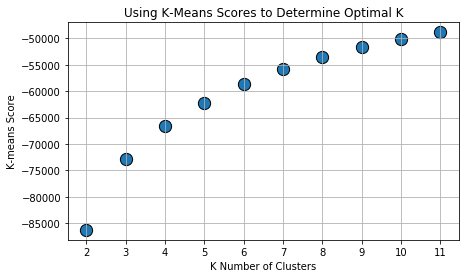

In [12]:
# Using Data Normalized with MinMax Scaler
# K-Means Score

plt.figure(figsize=(7,4))
plt.title("Using K-Means Scores to Determine Optimal K")
plt.scatter(x=[i for i in range(2,12)], y=km_scores_mms, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("K Number of Clusters")
plt.ylabel("K-means Score")
plt.xticks([i for i in range(2,12)])
plt.yticks()
plt.show()

**Calinski Harabasz Score**

Like most internal clustering criteria, Calinski-Harabasz is a heuristic device. The proper way to use it is to compare clustering solutions obtained on the same data, - solutions which differ either by the number of clusters or by the clustering method used.

There is no "acceptable" cut-off value. You simply compare CH values by eye. The higher the value, the "better" is the solution. If on the line-plot of CH values there appears that one solution give a peak or at least an abrupt elbow, choose it. If, on the contrary, the line is smooth - horizontal or ascending or descending - then there is no reason to prefer one solution to others.

CH criterion is based on ANOVA ideology. Hence, it implies that the clustered objects lie in Euclidean space of scale (not ordinal or binary or nominal) variables. If the data clustered were not objects X variables but a matrix of dissimilarities between objects then the dissimilarity measure should be (squared) euclidean distance (or, at worse, am other metric distance approaching euclidean distance by properties).

CH criterion is most suitable in case when clusters are more or less spherical and compact in their middle (such as normally distributed, for instance)1. Other conditions being equal, CH tends to prefer cluster solutions with clusters consisting of roughly the same number of objects.

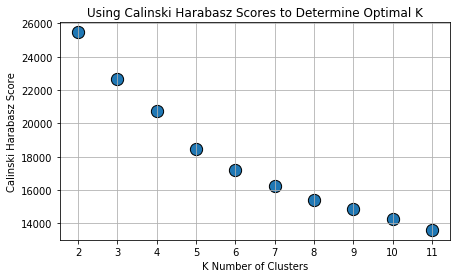

In [8]:
# Using Data Normalized with Standard Scaler
# Calinski Harabasz Score

plt.figure(figsize=(7,4))
plt.title("Using Calinski Harabasz Scores to Determine Optimal K")
plt.scatter(x=[i for i in range(2,12)], y=calinski_scores_ss, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("K Number of Clusters")
plt.ylabel("Calinski Harabasz Score")
plt.xticks([i for i in range(2,12)])
plt.yticks()
plt.show()

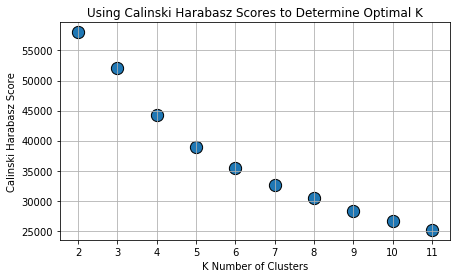

In [13]:
# Using Data Normalized with MinMax Scaler
# Calinski Harabasz Score

plt.figure(figsize=(7,4))
plt.title("Using Calinski Harabasz Scores to Determine Optimal K")
plt.scatter(x=[i for i in range(2,12)], y=calinski_scores_mms, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("K Number of Clusters")
plt.ylabel("Calinski Harabasz Score")
plt.xticks([i for i in range(2,12)])
plt.yticks()
plt.show()

**Silhouette Coefficient**

The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

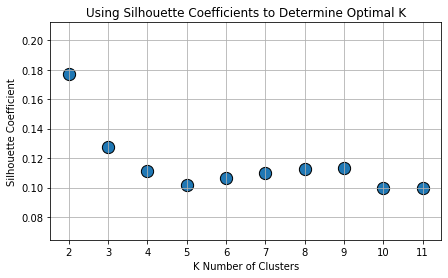

In [9]:
# Using Data Normalized with Standard Scaler
# Silhouette Coefficient

plt.figure(figsize=(7,4))
plt.title("Using Silhouette Coefficients to Determine Optimal K")
plt.scatter(x=[i for i in range(2,12)], y=silhouette_scores_ss, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("K Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.xticks([i for i in range(2,12)])
plt.yticks()
plt.show()

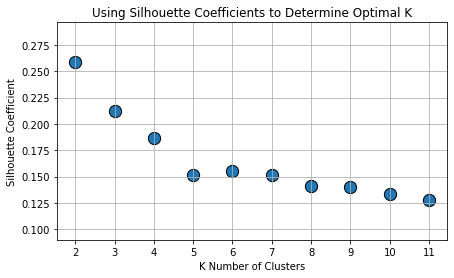

In [14]:
# Using Data Normalized with MinMax Scaler
# Silhouette Coefficient

plt.figure(figsize=(7,4))
plt.title("Using Silhouette Coefficients to Determine Optimal K")
plt.scatter(x=[i for i in range(2,12)], y=silhouette_scores_mms, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("K Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.xticks([i for i in range(2,12)])
plt.yticks()
plt.show()

**Davies Bouldin Score**

With this formulation, the lower the value, the better the separation of the clusters and the 'tightness' inside the clusters. Due to the way it is defined, as a function of the ratio of the within cluster scatter, to the between cluster separation, a lower value will mean that the clustering is better.

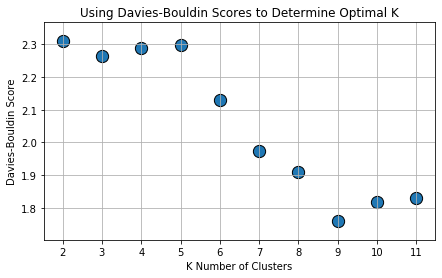

In [10]:
# Using Data Normalized with Standard Scaler
# Davies Bouldin Score

plt.figure(figsize=(7,4))
plt.title("Using Davies-Bouldin Scores to Determine Optimal K")
plt.scatter(x=[i for i in range(2,12)], y=davies_scores_ss, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("K Number of Clusters")
plt.ylabel("Davies-Bouldin Score")
plt.xticks([i for i in range(2,12)])
plt.yticks()
plt.show()

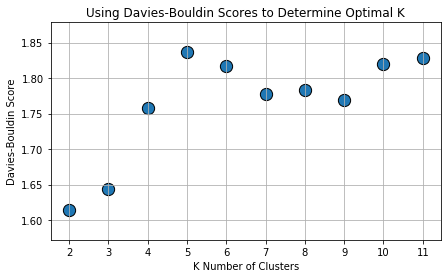

In [15]:
# Using Data Normalized with MinMax Scaler
# Davies Bouldin Score

plt.figure(figsize=(7,4))
plt.title("Using Davies-Bouldin Scores to Determine Optimal K")
plt.scatter(x=[i for i in range(2,12)], y=davies_scores_mms, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("K Number of Clusters")
plt.ylabel("Davies-Bouldin Score")
plt.xticks([i for i in range(2,12)])
plt.yticks()
plt.show()

### BIC Score with Gaussian Mixture Model

GMM is an extension of K-Means that treats a blob of data as a superimposition of multiple Gaussian datasets with separate mean and variances. Then it applies the Expectation-Maximization (EM) algorithm to determine these mean and variances approximately.

Bayesian Information Criterion (BIC) used as regularization techniques in linear regression for the variable selection process.

https://towardsdatascience.com/clustering-metrics-better-than-the-elbow-method-6926e1f723a6

https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Clustering-Dimensionality-Reduction/Clustering_metrics.ipynb

https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Clustering-Dimensionality-Reduction/Hierarchical_Clustering.ipynb

In [16]:
# Using Data Normalized with Standard Scaler
# Fitting Gaussian Mixture Model for 2-11 Components

from sklearn.mixture import GaussianMixture

gm_bic_ss = []
gm_bic_neg_ss = []
gm_score_ss = []
for i in range(2, 12):
    print("-", i, 'Components')
    gm = GaussianMixture(n_components=i,
                         n_init=10,
                         tol=1e-3,
                         max_iter=1000).fit(X_train_sscaled)
    
    gm_bic_ss.append(gm.bic(X_train_sscaled))
    gm_bic_neg_ss.append(-gm.bic(X_train_sscaled))
    print("BIC:", gm.bic(X_train_sscaled))
    
    gm_score_ss.append(gm.score(X_train_sscaled))
    print("Log-Likelihood Score:", gm.score(X_train_sscaled))
    
    print("-"*45)

BIC for 2 number of clusters: 9850716.680988712
Log-likelihood score for 2 clusters: -25.33236668667046
----------------------------------------------------------------------------------------------------
BIC for 3 number of clusters: 8858791.122770038
Log-likelihood score for 3 clusters: -22.767273550560553
----------------------------------------------------------------------------------------------------
BIC for 4 number of clusters: 6097721.395107474
Log-likelihood score for 4 clusters: -15.64835188225498
----------------------------------------------------------------------------------------------------
BIC for 5 number of clusters: 5620673.259651928
Log-likelihood score for 5 clusters: -14.408568203032994
----------------------------------------------------------------------------------------------------
BIC for 6 number of clusters: 5005529.621125742
Log-likelihood score for 6 clusters: -12.813322683610231
-------------------------------------------------------------------------

In [20]:
# Using Data Normalized with MinMax Scaler
# Fitting Gaussian Mixture Model for 2-11 Components

from sklearn.mixture import GaussianMixture

gm_bic_mms = []
gm_bic_neg_mms = []
gm_score_mms = []
for i in range(2, 12):
    print("-", i, 'Components')
    gm = GaussianMixture(n_components=i,
                         n_init=10,
                         tol=1e-3,
                         max_iter=1000).fit(X_train_mmscaled)
    
    gm_bic_mms.append(gm.bic(X_train_mmscaled))
    gm_bic_neg_mms.append(-gm.bic(X_train_mmscaled))
    print("BIC:", gm.bic(X_train_mmscaled))
    
    gm_score_mms.append(gm.score(X_train_mmscaled))
    print("Log-Likelihood Score:", gm.score(X_train_mmscaled))
    
    print("-"*45)

BIC for 2 number of clusters: -12891673.270988336
Log-likelihood score for 2 clusters: 33.20720631273506
----------------------------------------------------------------------------------------------------
BIC for 3 number of clusters: -14258068.080371417
Log-likelihood score for 3 clusters: 36.73619418949714
----------------------------------------------------------------------------------------------------
BIC for 4 number of clusters: -14710733.19484394
Log-likelihood score for 4 clusters: 37.913215263742444
----------------------------------------------------------------------------------------------------
BIC for 5 number of clusters: -16315726.782869244
Log-likelihood score for 5 clusters: 42.05636333428315
----------------------------------------------------------------------------------------------------
BIC for 6 number of clusters: -16714189.296830986
Log-likelihood score for 6 clusters: 43.09386533880629
-----------------------------------------------------------------------

gm_bic

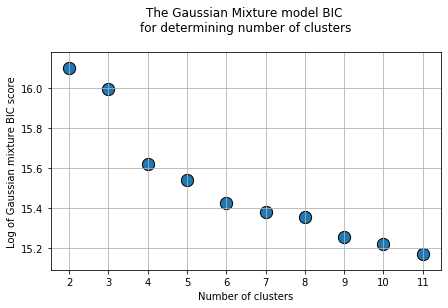

In [17]:
# Using Data Normalized with Standard Scaler
# 

plt.figure(figsize=(7,4))
plt.title("The Gaussian Mixture model BIC \nfor determining number of clusters\n")
plt.scatter(x=[i for i in range(2,12)],y=np.log(gm_bic_ss),s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters")
plt.ylabel("Log of Gaussian mixture BIC score")
plt.xticks([i for i in range(2,12)])
plt.yticks()
plt.show()

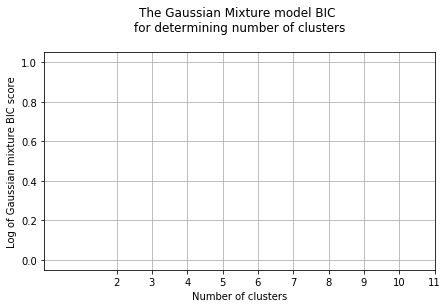

In [21]:
# Using Data Normalized with MinMax Scaler
# 

plt.figure(figsize=(7,4))
plt.title("The Gaussian Mixture model BIC \nfor determining number of clusters\n")
plt.scatter(x=[i for i in range(2,12)],y=np.log(gm_bic_mms),s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters")
plt.ylabel("Log of Gaussian mixture BIC score")
plt.xticks([i for i in range(2,12)])
plt.yticks()
plt.show()

gm_bic_neg

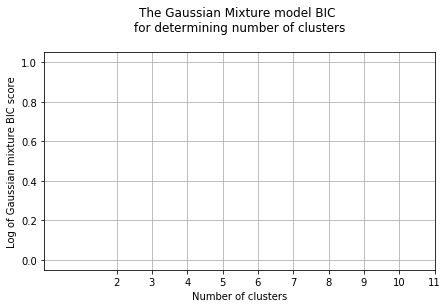

In [18]:
# Using Data Normalized with Standard Scaler
# 

plt.figure(figsize=(7,4))
plt.title("The Gaussian Mixture model BIC \nfor determining number of clusters\n")
plt.scatter(x=[i for i in range(2,12)],y=np.log(gm_bic_neg_ss),s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters")
plt.ylabel("Log of Gaussian mixture BIC score")
plt.xticks([i for i in range(2,12)])
plt.yticks()
plt.show()

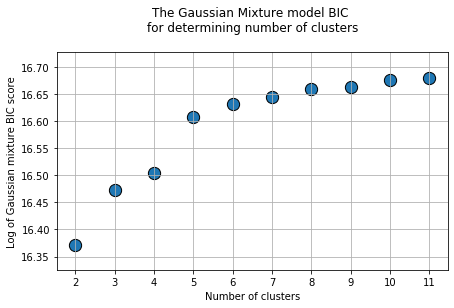

In [22]:
# Using Data Normalized with MinMax Scaler
# 

plt.figure(figsize=(7,4))
plt.title("The Gaussian Mixture model BIC \nfor determining number of clusters\n")
plt.scatter(x=[i for i in range(2,12)],y=np.log(gm_bic_neg_mms),s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters")
plt.ylabel("Log of Gaussian mixture BIC score")
plt.xticks([i for i in range(2,12)])
plt.yticks()
plt.show()

gm_score

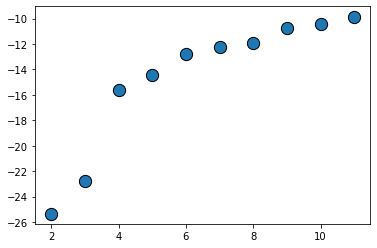

In [19]:
# Using Data Normalized with Standard Scaler
# 

plt.scatter(x=[i for i in range(2,12)],y=gm_score_ss,s=150,edgecolor='k')
plt.show()

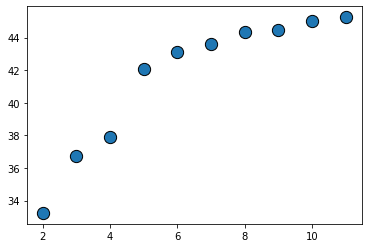

In [23]:
# Using Data Normalized with MinMax Scaler
# 

plt.scatter(x=[i for i in range(2,12)],y=gm_score_mms,s=150,edgecolor='k')
plt.show()

## K-Means w/ PCA

use optimal scaler  
use optimal k

### Reduce Dimensionality w/ PCA

**Transform Normalized X_train with 2-11 Number of Components**

In [6]:
# Using Data Normalized with Standard Scaler
# Reducing dimensionality with PCA

from sklearn.decomposition import PCA

pca2 = PCA(n_components=2)
X_train_sscaled_pca2 = pca2.fit_transform(X_train_sscaled)

pca3 = PCA(n_components=3)
X_train_sscaled_pca3 = pca3.fit_transform(X_train_sscaled)

pca4 = PCA(n_components=4)
X_train_sscaled_pca4 = pca4.fit_transform(X_train_sscaled)

pca5 = PCA(n_components=5)
X_train_sscaled_pca5 = pca5.fit_transform(X_train_sscaled)

pca6 = PCA(n_components=6)
X_train_sscaled_pca6 = pca6.fit_transform(X_train_sscaled)

pca7 = PCA(n_components=7)
X_train_sscaled_pca7 = pca7.fit_transform(X_train_sscaled)

pca8 = PCA(n_components=8)
X_train_sscaled_pca8 = pca8.fit_transform(X_train_sscaled)

pca9 = PCA(n_components=9)
X_train_sscaled_pca9 = pca9.fit_transform(X_train_sscaled)

pca10 = PCA(n_components=10)
X_train_sscaled_pca10 = pca10.fit_transform(X_train_sscaled)

pca11 = PCA(n_components=11)
X_train_sscaled_pca11 = pca11.fit_transform(X_train_sscaled)

In [7]:
# Using Data Normalized with MinMax Scaler
# Reducing dimensionality with PCA

from sklearn.decomposition import PCA

pca2 = PCA(n_components=2)
X_train_mmscaled_pca2 = pca2.fit_transform(X_train_mmscaled)

pca3 = PCA(n_components=3)
X_train_mmscaled_pca3 = pca3.fit_transform(X_train_mmscaled)

pca4 = PCA(n_components=4)
X_train_mmscaled_pca4 = pca4.fit_transform(X_train_mmscaled)

pca5 = PCA(n_components=5)
X_train_mmscaled_pca5 = pca5.fit_transform(X_train_mmscaled)

pca6 = PCA(n_components=6)
X_train_mmscaled_pca6 = pca6.fit_transform(X_train_mmscaled)

pca7 = PCA(n_components=7)
X_train_mmscaled_pca7 = pca7.fit_transform(X_train_mmscaled)

pca8 = PCA(n_components=8)
X_train_mmscaled_pca8 = pca8.fit_transform(X_train_mmscaled)

pca9 = PCA(n_components=9)
X_train_mmscaled_pca9 = pca9.fit_transform(X_train_mmscaled)

pca10 = PCA(n_components=10)
X_train_mmscaled_pca10 = pca10.fit_transform(X_train_mmscaled)

pca11 = PCA(n_components=11)
X_train_mmscaled_pca11 = pca11.fit_transform(X_train_mmscaled)

**Define Lists of PCA Datasets**

In [26]:
# Using Data Normalized with Standard Scaler
# List of PCA Datasets

X_train_pca_ss_list = [X_train_sscaled_pca2,
X_train_sscaled_pca3,
X_train_sscaled_pca4,
X_train_sscaled_pca5,
X_train_sscaled_pca6,
X_train_sscaled_pca7,
X_train_sscaled_pca8,
X_train_sscaled_pca9,
X_train_sscaled_pca10,
X_train_sscaled_pca11]

In [27]:
# Using Data Normalized with MinMax Scaler
# List of PCA Datasets

X_train_pca_mms_list = [X_train_mmscaled_pca2,
X_train_mmscaled_pca3,
X_train_mmscaled_pca4,
X_train_mmscaled_pca5,
X_train_mmscaled_pca6,
X_train_mmscaled_pca7,
X_train_mmscaled_pca8,
X_train_mmscaled_pca9,
X_train_mmscaled_pca10,
X_train_mmscaled_pca11]

### Standard Scaler vs MinMax Scaler

In [28]:
# Using Data Normalized with Standard Scaler
# Fitting K-Means Model for 2-11 Clusters

from sklearn.cluster import KMeans 
from sklearn import metrics
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score

km_scores_pca_ss = []
calinski_scores_pca_ss = []
silhouette_scores_pca_ss = []
davies_scores_pca_ss = []
for x in X_train_pca_ss_list:
    print("-", i, 'Clusters')
    km = KMeans(n_clusters=2, random_state=0, n_jobs=-2).fit(x)
    preds = km.predict(x)
    
    km_score = km.score(x)
    km_scores_pca_ss.append(km_score)
    print("K-Means Score:", km_score)
    
    calinski = calinski_harabasz_score(x,preds)
    calinski_scores_pca_ss.append(calinski)
    print("Calinski Harabasz Score:", calinski)

    silhouette = silhouette_score(x,preds)
    silhouette_scores_pca_ss.append(silhouette)
    print("Silhouette Score:", silhouette)
    
    db = davies_bouldin_score(x,preds)
    davies_scores_pca_ss.append(db)
    print("Davies Bouldin Score:", db)
    
    print("-"*45)

K-Means Score for 11 clusters: -976421.0459319399
Calinski Harabasz score for 11 clusters: 115600.64877195904
Silhouette score for 11 clusters: 0.41391428751033604
Davies Bouldin score for 11 clusters: 1.0085083026127146
--------------------------------------------------
K-Means Score for 11 clusters: -1423959.6135425495
Calinski Harabasz score for 11 clusters: 79575.35576283575
Silhouette score for 11 clusters: 0.33589922492991353
Davies Bouldin score for 11 clusters: 1.2588357272915218
--------------------------------------------------
K-Means Score for 11 clusters: -1780285.2360230235
Calinski Harabasz score for 11 clusters: 63719.88632722452
Silhouette score for 11 clusters: 0.2974059945014864
Davies Bouldin score for 11 clusters: 1.4089813884945361
--------------------------------------------------
K-Means Score for 11 clusters: -2118179.0749690104
Calinski Harabasz score for 11 clusters: 53561.42323906658
Silhouette score for 11 clusters: 0.26968818917194304
Davies Bouldin score 

In [29]:
# Using Data Normalized with MinMax Scaler
# Fitting K-Means Model for 2-11 Clusters

from sklearn.cluster import KMeans 
from sklearn import metrics
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score

km_scores_pca_mms = []
calinski_scores_pca_mms = []
silhouette_scores_pca_mms = []
davies_scores_pca_mms = []
for x in X_train_pca_mms_list:
    print("-", i, 'Clusters')
    km = KMeans(n_clusters=2, random_state=0, n_jobs=-2).fit(x)
    preds = km.predict(x)
    
    km_score = km.score(x)
    km_scores_pca_mms.append(km_score)
    print("K-Means Score:", km_score)
    
    calinski = calinski_harabasz_score(x,preds)
    calinski_scores_pca_mms.append(calinski)
    print("Calinski Harabasz Score:", calinski)

    silhouette = silhouette_score(x,preds)
    silhouette_scores_pca_mms.append(silhouette)
    print("Silhouette Score:", silhouette)
    
    db = davies_bouldin_score(x,preds)
    davies_scores_pca_mms.append(db)
    print("Davies Bouldin Score:", db)
    
    print("-"*45)

K-Means Score for 11 clusters: -29851.57994477436
Calinski Harabasz score for 11 clusters: 167278.87953214548
Silhouette score for 11 clusters: 0.46678768002644505
Davies Bouldin score for 11 clusters: 0.9109422029292843
--------------------------------------------------
K-Means Score for 11 clusters: -41054.83179542907
Calinski Harabasz score for 11 clusters: 121721.57819369495
Silhouette score for 11 clusters: 0.3975491324390208
Davies Bouldin score for 11 clusters: 1.0807639332296177
--------------------------------------------------
K-Means Score for 11 clusters: -50213.427391082674
Calinski Harabasz score for 11 clusters: 99520.7555924128
Silhouette score for 11 clusters: 0.35674927973210013
Davies Bouldin score for 11 clusters: 1.2110823386478133
--------------------------------------------------
K-Means Score for 11 clusters: -57855.84325526867
Calinski Harabasz score for 11 clusters: 86375.16177484812
Silhouette score for 11 clusters: 0.32757281826173734
Davies Bouldin score fo

### Evaluate Scores to Find Best N PCA Components

**K-Means Score**

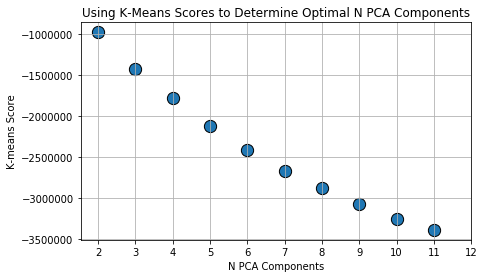

In [30]:
# Using Data Normalized with Standard Scaler
# K-Means Score

plt.figure(figsize=(7,4))
plt.title("Using K-Means Scores to Determine Optimal N PCA Components")
plt.scatter(x=[i for i in range(2,12)], y=km_scores_pca_ss, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("N PCA Components")
plt.ylabel("K-means Score")
plt.xticks([i for i in range(2,13)])
plt.yticks()
plt.show()

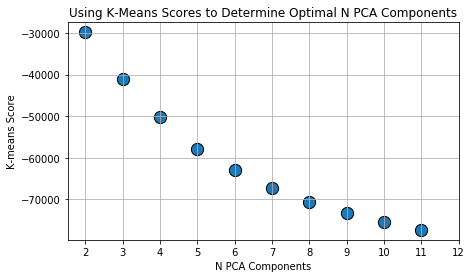

In [31]:
# Using Data Normalized with MinMax Scaler
# K-Means Score

plt.figure(figsize=(7,4))
plt.title("Using K-Means Scores to Determine Optimal N PCA Components")
plt.scatter(x=[i for i in range(2,12)], y=km_scores_pca_mms, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("N PCA Components")
plt.ylabel("K-means Score")
plt.xticks([i for i in range(2,13)])
plt.yticks()
plt.show()

**Calinski Harabasz Score**

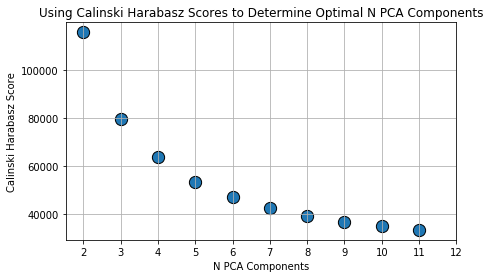

In [32]:
# Using Data Normalized with Standard Scaler
# Calinski Harabasz Score

plt.figure(figsize=(7,4))
plt.title("Using Calinski Harabasz Scores to Determine Optimal N PCA Components")
plt.scatter(x=[i for i in range(2,12)], y=calinski_scores_pca_ss, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("N PCA Components")
plt.ylabel("Calinski Harabasz Score")
plt.xticks([i for i in range(2,13)])
plt.yticks()
plt.show()

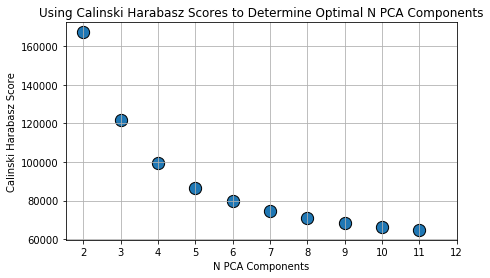

In [33]:
# Using Data Normalized with MinMax Scaler
# Calinski Harabasz Score

plt.figure(figsize=(7,4))
plt.title("Using Calinski Harabasz Scores to Determine Optimal N PCA Components")
plt.scatter(x=[i for i in range(2,12)], y=calinski_scores_pca_mms, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("N PCA Components")
plt.ylabel("Calinski Harabasz Score")
plt.xticks([i for i in range(2,13)])
plt.yticks()
plt.show()

**Silhouette Coefficient**

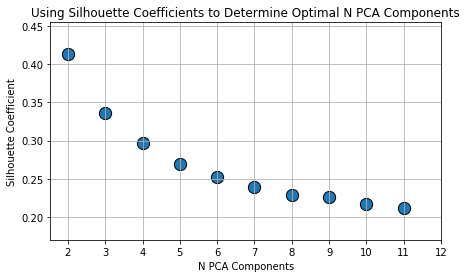

In [34]:
# Using Data Normalized with Standard Scaler
# Silhouette Coefficient

plt.figure(figsize=(7,4))
plt.title("Using Silhouette Coefficients to Determine Optimal N PCA Components")
plt.scatter(x=[i for i in range(2,12)], y=silhouette_scores_pca_ss, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("N PCA Components")
plt.ylabel("Silhouette Coefficient")
plt.xticks([i for i in range(2,13)])
plt.yticks()
plt.show()

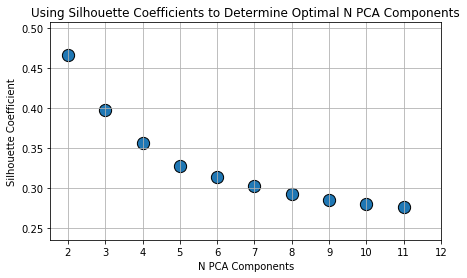

In [35]:
# Using Data Normalized with MinMax Scaler
# Silhouette Coefficient

plt.figure(figsize=(7,4))
plt.title("Using Silhouette Coefficients to Determine Optimal N PCA Components")
plt.scatter(x=[i for i in range(2,12)], y=silhouette_scores_pca_mms, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("N PCA Components")
plt.ylabel("Silhouette Coefficient")
plt.xticks([i for i in range(2,13)])
plt.yticks()
plt.show()

**Davies Bouldin Score**

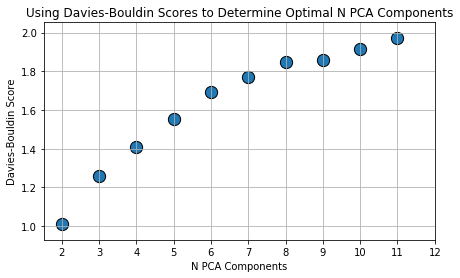

In [36]:
# Using Data Normalized with Standard Scaler
# Davies Bouldin Score

plt.figure(figsize=(7,4))
plt.title("Using Davies-Bouldin Scores to Determine Optimal N PCA Components")
plt.scatter(x=[i for i in range(2,12)], y=davies_scores_pca_ss, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("N PCA Components")
plt.ylabel("Davies-Bouldin Score")
plt.xticks([i for i in range(2,13)])
plt.yticks()
plt.show()

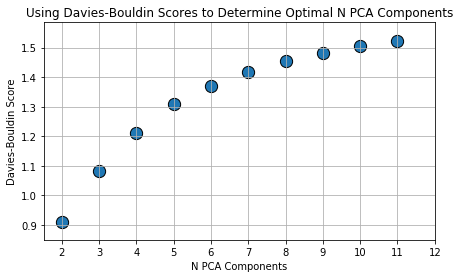

In [37]:
# Using Data Normalized with MinMax Scaler
# Davies Bouldin Score

plt.figure(figsize=(7,4))
plt.title("Using Davies-Bouldin Scores to Determine Optimal N PCA Components")
plt.scatter(x=[i for i in range(2,12)], y=davies_scores_pca_mms, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("N PCA Components")
plt.ylabel("Davies-Bouldin Score")
plt.xticks([i for i in range(2,13)])
plt.yticks()
plt.show()

### K-Means (PCA = 2)

#### Standard Scaler vs MinMax Scaler

In [9]:
# Using Data Normalized with Standard Scaler
# Fitting K-Means Model for 2-11 Clusters

from sklearn.cluster import KMeans 
from sklearn import metrics
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score

km_scores_pca2_ss = []
calinski_scores_pca2_ss = []
silhouette_scores_pca2_ss = []
davies_scores_pca2_ss = []
for i in range(2,7):
    print("-", i, 'Clusters')
    km = KMeans(n_clusters=i, random_state=0, n_jobs=-2).fit(X_train_sscaled_pca2)
    preds = km.predict(X_train_sscaled_pca2)
    
    km_score = km.score(X_train_sscaled_pca2)
    km_scores_pca2_ss.append(km_score)
    print("K-Means Score:", km_score)
    
    calinski = calinski_harabasz_score(X_train_sscaled_pca2,preds)
    calinski_scores_pca2_ss.append(calinski)
    print("Calinski Harabasz Score:", calinski)

    silhouette = silhouette_score(X_train_sscaled_pca2,preds)
    silhouette_scores_pca2_ss.append(silhouette)
    print("Silhouette Score:", silhouette)
    
    db = davies_bouldin_score(X_train_sscaled_pca2,preds)
    davies_scores_pca2_ss.append(db)
    print("Davies Bouldin Score:", db)
    
    print("-"*45)

K-Means Score for 2 clusters: -976421.0517406543
Calinski Harabasz score for 2 clusters: 115600.64692861329
Silhouette score for 2 clusters: 0.41391426592302444
Davies Bouldin score for 2 clusters: 1.0085082523458526
-----------------------------------------------------------------
K-Means Score for 3 clusters: -615342.4859768201
Calinski Harabasz score for 3 clusters: 148708.33687620537
Silhouette score for 3 clusters: 0.42201946014520686
Davies Bouldin score for 3 clusters: 0.8329248424212391
-----------------------------------------------------------------
K-Means Score for 4 clusters: -472024.3482771584
Calinski Harabasz score for 4 clusters: 148897.57115394546
Silhouette score for 4 clusters: 0.36120917740528
Davies Bouldin score for 4 clusters: 0.9183212918470098
-----------------------------------------------------------------
K-Means Score for 5 clusters: -376277.8955064197
Calinski Harabasz score for 5 clusters: 152446.10407547487
Silhouette score for 5 clusters: 0.35501867414

In [21]:
# Using Data Normalized with MinMax Scaler
# Fitting K-Means Model for 2-11 Clusters

from sklearn.cluster import KMeans 
from sklearn import metrics
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score

km_scores_pca2_mms = []
calinski_scores_pca2_mms = []
silhouette_scores_pca2_mms = []
davies_scores_pca2_mms = []
for i in range(2,7):
    print("-", i, 'Clusters')
    km = KMeans(n_clusters=i, random_state=0, n_jobs=-2).fit(X_train_mmscaled_pca2)
    preds = km.predict(X_train_mmscaled_pca2)
    
    km_score = km.score(X_train_mmscaled_pca2)
    km_scores_pca2_mms.append(km_score)
    print("K-Means Score:", km_score)
    
    calinski = calinski_harabasz_score(X_train_mmscaled_pca2,preds)
    calinski_scores_pca2_mms.append(calinski)
    print("Calinski Harabasz Score:", calinski)

    silhouette = silhouette_score(X_train_mmscaled_pca2,preds)
    silhouette_scores_pca2_mms.append(silhouette)
    print("Silhouette Score:", silhouette)
    
    db = davies_bouldin_score(X_train_mmscaled_pca2,preds)
    davies_scores_pca2_mms.append(db)
    print("Davies Bouldin Score:", db)
    
    print("-"*45)

K-Means Score for 2 clusters: -29851.57994479282
Calinski Harabasz score for 2 clusters: 167278.8795319192
Silhouette score for 2 clusters: 0.46678768002673077
Davies Bouldin score for 2 clusters: 0.9109422029314738
-----------------------------------------------------------------
K-Means Score for 3 clusters: -16809.986779735224
Calinski Harabasz score for 3 clusters: 223878.34272969057
Silhouette score for 3 clusters: 0.4865577633015307
Davies Bouldin score for 3 clusters: 0.7009814696126884
-----------------------------------------------------------------
K-Means Score for 4 clusters: -10678.642770280969
Calinski Harabasz score for 4 clusters: 272123.04678788886
Silhouette score for 4 clusters: 0.4921026318731002
Davies Bouldin score for 4 clusters: 0.6765774536867577
-----------------------------------------------------------------
K-Means Score for 5 clusters: -8751.994958605184
Calinski Harabasz score for 5 clusters: 259712.35444614722
Silhouette score for 5 clusters: 0.426067917

#### Evaluate Scores to Find Best K

**K-Means Score**

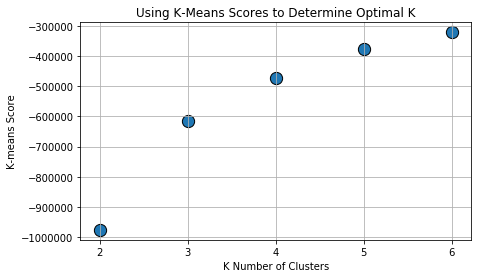

In [20]:
# Using Data Normalized with Standard Scaler
# K-Means Score

plt.figure(figsize=(7,4))
plt.title("Using K-Means Scores to Determine Optimal K")
plt.scatter(x=[i for i in range(2,7)], y=km_scores_pca2_ss, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("K Number of Clusters")
plt.ylabel("K-means Score")
plt.xticks([i for i in range(2,7)])
plt.yticks()
plt.show()

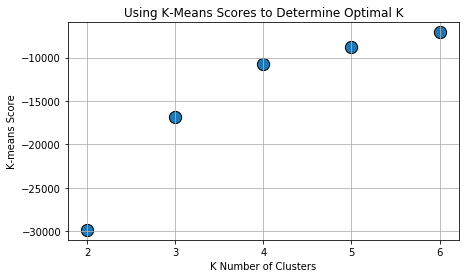

In [24]:
# Using Data Normalized with MinMax Scaler
# K-Means Score

plt.figure(figsize=(7,4))
plt.title("Using K-Means Scores to Determine Optimal K")
plt.scatter(x=[i for i in range(2,7)], y=km_scores_pca2_mms, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("K Number of Clusters")
plt.ylabel("K-means Score")
plt.xticks([i for i in range(2,7)])
plt.yticks()
plt.show()

**Calinski Harabasz Score**

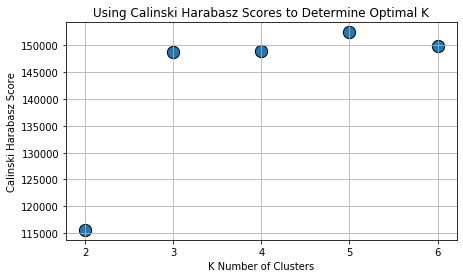

In [19]:
# Using Data Normalized with Standard Scaler
# Calinski Harabasz Score

plt.figure(figsize=(7,4))
plt.title("Using Calinski Harabasz Scores to Determine Optimal K")
plt.scatter(x=[i for i in range(2,7)], y=calinski_scores_pca2_ss, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("K Number of Clusters")
plt.ylabel("Calinski Harabasz Score")
plt.xticks([i for i in range(2,7)])
plt.yticks()
plt.show()

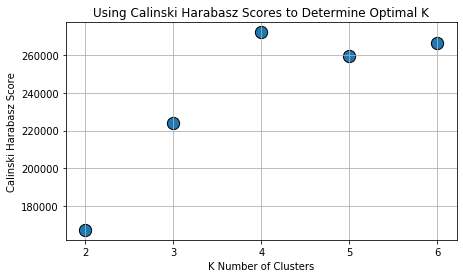

In [25]:
# Using Data Normalized with MinMax Scaler
# Calinski Harabasz Score

plt.figure(figsize=(7,4))
plt.title("Using Calinski Harabasz Scores to Determine Optimal K")
plt.scatter(x=[i for i in range(2,7)], y=calinski_scores_pca2_mms, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("K Number of Clusters")
plt.ylabel("Calinski Harabasz Score")
plt.xticks([i for i in range(2,7)])
plt.yticks()
plt.show()

**Silhouette Coefficient**

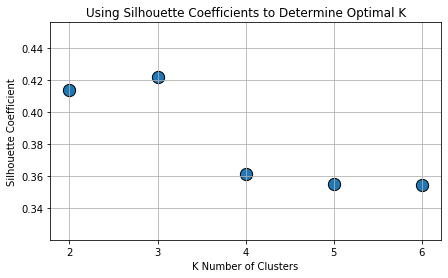

In [18]:
# Using Data Normalized with Standard Scaler
# Silhouette Coefficient

plt.figure(figsize=(7,4))
plt.title("Using Silhouette Coefficients to Determine Optimal K")
plt.scatter(x=[i for i in range(2,7)], y=silhouette_scores_pca2_ss, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("K Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.xticks([i for i in range(2,7)])
plt.yticks()
plt.show()

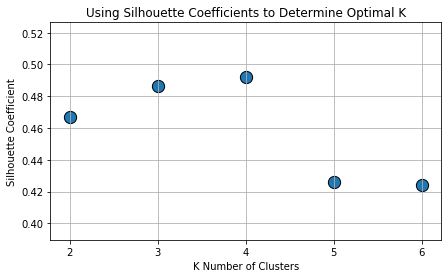

In [26]:
# Using Data Normalized with MinMax Scaler
# Silhouette Coefficient

plt.figure(figsize=(7,4))
plt.title("Using Silhouette Coefficients to Determine Optimal K")
plt.scatter(x=[i for i in range(2,7)], y=silhouette_scores_pca2_mms, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("K Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.xticks([i for i in range(2,7)])
plt.yticks()
plt.show()

**Davies Bouldin Score**

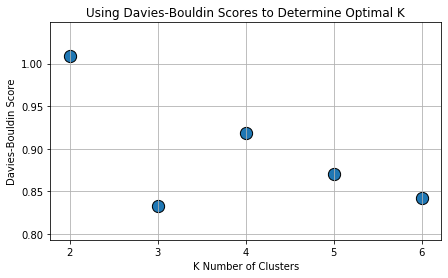

In [17]:
# Using Data Normalized with Standard Scaler
# Davies Bouldin Score

plt.figure(figsize=(7,4))
plt.title("Using Davies-Bouldin Scores to Determine Optimal K")
plt.scatter(x=[i for i in range(2,7)], y=davies_scores_pca2_ss, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("K Number of Clusters")
plt.ylabel("Davies-Bouldin Score")
plt.xticks([i for i in range(2,7)])
plt.yticks()
plt.show()

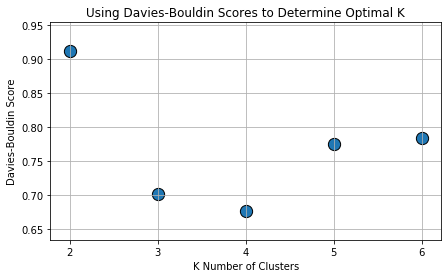

In [27]:
# Using Data Normalized with MinMax Scaler
# Davies Bouldin Score

plt.figure(figsize=(7,4))
plt.title("Using Davies-Bouldin Scores to Determine Optimal K")
plt.scatter(x=[i for i in range(2,7)], y=davies_scores_pca2_mms, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("K Number of Clusters")
plt.ylabel("Davies-Bouldin Score")
plt.xticks([i for i in range(2,7)])
plt.yticks()
plt.show()

### K-Means (PCA = 3)

#### Standard Scaler vs MinMax Scaler

In [34]:
# Using Data Normalized with Standard Scaler
# Fitting K-Means Model for 2-11 Clusters

from sklearn.cluster import KMeans 
from sklearn import metrics
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score

km_scores_pca3_ss = []
calinski_scores_pca3_ss = []
silhouette_scores_pca3_ss = []
davies_scores_pca3_ss = []
for i in range(2,7):
    print("-", i, 'Clusters')
    km = KMeans(n_clusters=i, random_state=0, n_jobs=-2).fit(X_train_sscaled_pca3)
    preds = km.predict(X_train_sscaled_pca3)
    
    km_score = km.score(X_train_sscaled_pca3)
    km_scores_pca3_ss.append(km_score)
    print("K-Means Score:", km_score)
    
    calinski = calinski_harabasz_score(X_train_sscaled_pca3,preds)
    calinski_scores_pca3_ss.append(calinski)
    print("Calinski Harabasz Score:", calinski)

    silhouette = silhouette_score(X_train_sscaled_pca3,preds)
    silhouette_scores_pca3_ss.append(silhouette)
    print("Silhouette Score:", silhouette)
    
    db = davies_bouldin_score(X_train_sscaled_pca3,preds)
    davies_scores_pca3_ss.append(db)
    print("Davies Bouldin Score:", db)
    
    print("-"*45)

- 2 Clusters
K-Means Score: -1423975.8858600326
Calinski Harabasz Score: 79572.97247697171
Silhouette Score: 0.3358227286123689
Davies Bouldin Score: 1.25890074399984
---------------------------------------------
- 3 Clusters
K-Means Score: -1062816.2345203194
Calinski Harabasz Score: 86310.19000704447
Silhouette Score: 0.30584944752580473
Davies Bouldin Score: 1.1469018247494092
---------------------------------------------
- 4 Clusters
K-Means Score: -810409.5221070595
Calinski Harabasz Score: 95626.44868463402
Silhouette Score: 0.3201131641734595
Davies Bouldin Score: 1.0344856653395482
---------------------------------------------
- 5 Clusters
K-Means Score: -680155.5359360952
Calinski Harabasz Score: 94753.90103543282
Silhouette Score: 0.3102579778484414
Davies Bouldin Score: 1.0157331603008193
---------------------------------------------
- 6 Clusters
K-Means Score: -619258.2129356521
Calinski Harabasz Score: 87077.63630270673
Silhouette Score: 0.2890326239634315
Davies Bouldin S

In [39]:
# Using Data Normalized with MinMax Scaler
# Fitting K-Means Model for 2-11 Clusters

from sklearn.cluster import KMeans 
from sklearn import metrics
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score

km_scores_pca3_mms = []
calinski_scores_pca3_mms = []
silhouette_scores_pca3_mms = []
davies_scores_pca3_mms = []
for i in range(2,7):
    print("-", i, 'Clusters')
    km = KMeans(n_clusters=i, random_state=0, n_jobs=-2).fit(X_train_mmscaled_pca3)
    preds = km.predict(X_train_mmscaled_pca3)
    
    km_score = km.score(X_train_mmscaled_pca3)
    km_scores_pca3_mms.append(km_score)
    print("K-Means Score:", km_score)
    
    calinski = calinski_harabasz_score(X_train_mmscaled_pca3,preds)
    calinski_scores_pca3_mms.append(calinski)
    print("Calinski Harabasz Score:", calinski)

    silhouette = silhouette_score(X_train_mmscaled_pca3,preds)
    silhouette_scores_pca3_mms.append(silhouette)
    print("Silhouette Score:", silhouette)
    
    db = davies_bouldin_score(X_train_mmscaled_pca3,preds)
    davies_scores_pca3_mms.append(db)
    print("Davies Bouldin Score:", db)
    
    print("-"*45)

- 2 Clusters
K-Means Score: -41054.8317233962
Calinski Harabasz Score: 121721.57877313346
Silhouette Score: 0.39754917063156214
Davies Bouldin Score: 1.0807635808796965
---------------------------------------------
- 3 Clusters
K-Means Score: -27945.01629223876
Calinski Harabasz Score: 134974.7267964823
Silhouette Score: 0.38546970771261724
Davies Bouldin Score: 0.9369383073052595
---------------------------------------------
- 4 Clusters
K-Means Score: -21827.463732811768
Calinski Harabasz Score: 133349.21647291555
Silhouette Score: 0.3701060668444549
Davies Bouldin Score: 0.9804326428467022
---------------------------------------------
- 5 Clusters
K-Means Score: -18192.217912871194
Calinski Harabasz Score: 129699.74972836382
Silhouette Score: 0.333042829859548
Davies Bouldin Score: 0.9908984704804343
---------------------------------------------
- 6 Clusters
K-Means Score: -15825.833780597291
Calinski Harabasz Score: 125082.88434099831
Silhouette Score: 0.3278615038171068
Davies Bou

#### Evaluate Scores to Find Best K

**K-Means Score**

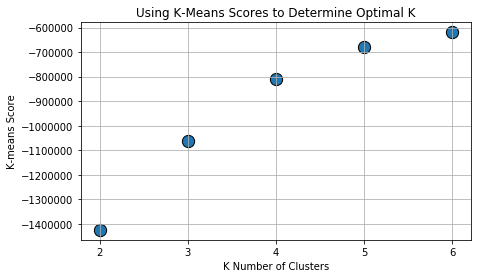

In [35]:
# Using Data Normalized with Standard Scaler
# K-Means Score

plt.figure(figsize=(7,4))
plt.title("Using K-Means Scores to Determine Optimal K")
plt.scatter(x=[i for i in range(2,7)], y=km_scores_pca3_ss, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("K Number of Clusters")
plt.ylabel("K-means Score")
plt.xticks([i for i in range(2,7)])
plt.yticks()
plt.show()

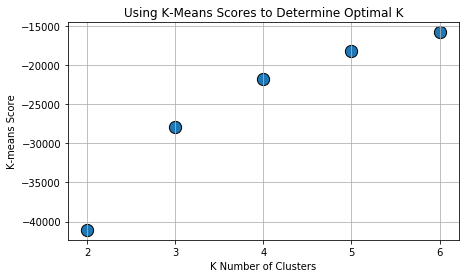

In [40]:
# Using Data Normalized with MinMax Scaler
# K-Means Score

plt.figure(figsize=(7,4))
plt.title("Using K-Means Scores to Determine Optimal K")
plt.scatter(x=[i for i in range(2,7)], y=km_scores_pca3_mms, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("K Number of Clusters")
plt.ylabel("K-means Score")
plt.xticks([i for i in range(2,7)])
plt.yticks()
plt.show()

**Calinski Harabasz Score**

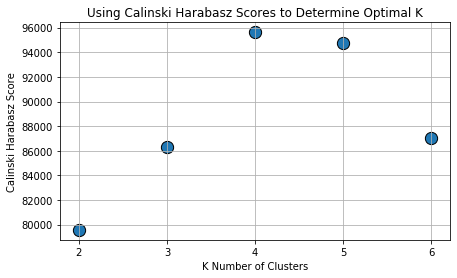

In [36]:
# Using Data Normalized with Standard Scaler
# Calinski Harabasz Score

plt.figure(figsize=(7,4))
plt.title("Using Calinski Harabasz Scores to Determine Optimal K")
plt.scatter(x=[i for i in range(2,7)], y=calinski_scores_pca3_ss, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("K Number of Clusters")
plt.ylabel("Calinski Harabasz Score")
plt.xticks([i for i in range(2,7)])
plt.yticks()
plt.show()

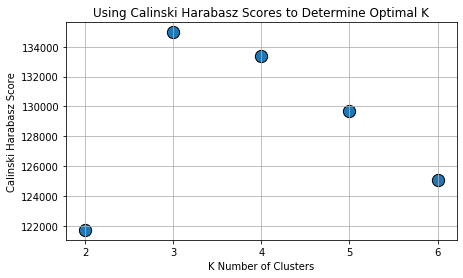

In [41]:
# Using Data Normalized with MinMax Scaler
# Calinski Harabasz Score

plt.figure(figsize=(7,4))
plt.title("Using Calinski Harabasz Scores to Determine Optimal K")
plt.scatter(x=[i for i in range(2,7)], y=calinski_scores_pca3_mms, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("K Number of Clusters")
plt.ylabel("Calinski Harabasz Score")
plt.xticks([i for i in range(2,7)])
plt.yticks()
plt.show()

**Silhouette Coefficient**

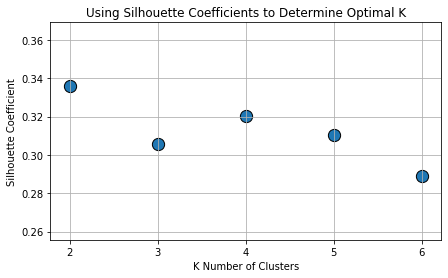

In [37]:
# Using Data Normalized with Standard Scaler
# Silhouette Coefficient

plt.figure(figsize=(7,4))
plt.title("Using Silhouette Coefficients to Determine Optimal K")
plt.scatter(x=[i for i in range(2,7)], y=silhouette_scores_pca3_ss, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("K Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.xticks([i for i in range(2,7)])
plt.yticks()
plt.show()

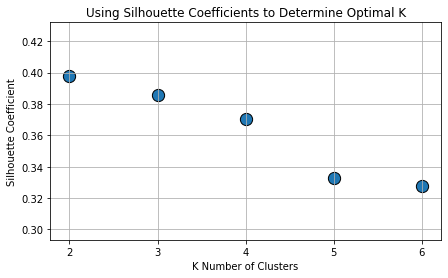

In [42]:
# Using Data Normalized with MinMax Scaler
# Silhouette Coefficient

plt.figure(figsize=(7,4))
plt.title("Using Silhouette Coefficients to Determine Optimal K")
plt.scatter(x=[i for i in range(2,7)], y=silhouette_scores_pca3_mms, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("K Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.xticks([i for i in range(2,7)])
plt.yticks()
plt.show()

**Davies Bouldin Score**

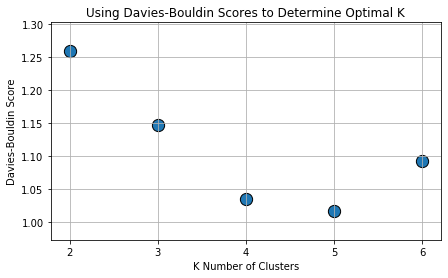

In [38]:
# Using Data Normalized with Standard Scaler
# Davies Bouldin Score

plt.figure(figsize=(7,4))
plt.title("Using Davies-Bouldin Scores to Determine Optimal K")
plt.scatter(x=[i for i in range(2,7)], y=davies_scores_pca3_ss, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("K Number of Clusters")
plt.ylabel("Davies-Bouldin Score")
plt.xticks([i for i in range(2,7)])
plt.yticks()
plt.show()

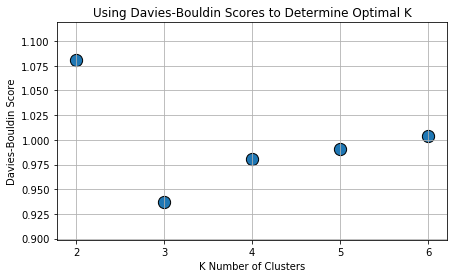

In [43]:
# Using Data Normalized with MinMax Scaler
# Davies Bouldin Score

plt.figure(figsize=(7,4))
plt.title("Using Davies-Bouldin Scores to Determine Optimal K")
plt.scatter(x=[i for i in range(2,7)], y=davies_scores_pca3_mms, s=150, edgecolor='k')
plt.grid(True)
plt.xlabel("K Number of Clusters")
plt.ylabel("Davies-Bouldin Score")
plt.xticks([i for i in range(2,7)])
plt.yticks()
plt.show()

### Optimal PCA

In [45]:
# Using Data Normalized with MinMax Scaler
# Fitting K-Means Model for 2-11 Clusters

from sklearn.cluster import KMeans 
from sklearn import metrics
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score


km = KMeans(n_clusters=3, random_state=0, n_jobs=-2).fit(X_train_mmscaled_pca2)
preds = km.predict(X_train_mmscaled_pca2)
    
km_score = km.score(X_train_mmscaled_pca2)
print("K-Means Score:", km_score)
    
calinski = calinski_harabasz_score(X_train_mmscaled_pca2,preds)
print("Calinski Harabasz Score:", calinski)

silhouette = silhouette_score(X_train_mmscaled_pca2,preds)
print("Silhouette Score:", silhouette)
    
db = davies_bouldin_score(X_train_mmscaled_pca2,preds)
print("Davies Bouldin Score:", db)
    


K-Means Score: -16809.986779735224
Calinski Harabasz Score: 223878.34272969057
Davies Bouldin Score: 0.7009814696126884


In [46]:
# Using Data Normalized with MinMax Scaler
# Fitting K-Means Model for 2-11 Clusters

from sklearn.cluster import KMeans 
from sklearn import metrics
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score


km = KMeans(n_clusters=3, random_state=0, n_jobs=-2).fit(X_train_mmscaled_pca3)
preds = km.predict(X_train_mmscaled_pca3)
    
km_score = km.score(X_train_mmscaled_pca3)
print("K-Means Score:", km_score)
    
calinski = calinski_harabasz_score(X_train_mmscaled_pca3,preds)
print("Calinski Harabasz Score:", calinski)

silhouette = silhouette_score(X_train_mmscaled_pca3,preds)
print("Silhouette Score:", silhouette)
    
db = davies_bouldin_score(X_train_mmscaled_pca3,preds)
print("Davies Bouldin Score:", db)
    


K-Means Score: -27945.01629223876
Calinski Harabasz Score: 134974.7267964823
Davies Bouldin Score: 0.9369383073052595


## K-Means Optimized Model

K = 3 (most votes between 3,4,5)  
Scaler = MinMax (leads to better scores)  
PCA = 2 (better scores)  

In [47]:
# Fitting K-Means Model for 3 Clusters
# Using Data Normalized with MinMax Scaler
# Dimensional Reduction w/ PCA to 2 Components

from sklearn.cluster import KMeans 

km = KMeans(n_clusters=3, random_state=0, n_jobs=-2).fit(X_train_mmscaled_pca2)
preds = km.predict(X_train_mmscaled_pca2)

In [ ]:
from sklearn import metrics
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score

km_score = km.score(X_train_mmscaled_pca2)
print("K-Means Score:", km_score)

calinski = calinski_harabasz_score(X_train_mmscaled_pca2,preds)
print("Calinski Harabasz Score:", calinski)

silhouette = silhouette_score(X_train_mmscaled_pca2,preds)
print("Silhouette Score:", silhouette)

db = davies_bouldin_score(X_train_mmscaled_pca2,preds)
print("Davies Bouldin Score:", db)

## EDA

In [63]:
# Create dataframe of predictions
preds_df = pd.DataFrame(preds)

# Merge preductions with X_train data
X_train_joined = pd.merge(preds_df, artists, left_index=True, right_index=True)

# Re-name prediction column
X_train_joined = X_train_joined.rename(columns={0: 'k_mean_pred'})

print(X_train_joined.info())
X_train_joined.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194248 entries, 0 to 194247
Data columns (total 29 columns):
k_mean_pred                194248 non-null int32
artist_id                  194248 non-null object
artist_name                191716 non-null object
artist_followers           194248 non-null float64
artist_popularity          194248 non-null float64
track_popularity_mean      194248 non-null float64
track_popularity_std       194248 non-null float64
track_release_year_mean    194248 non-null float64
track_release_year_std     194248 non-null float64
acousticness_mean          194248 non-null float64
acousticness_std           194248 non-null float64
danceability_mean          194248 non-null float64
danceability_std           194248 non-null float64
duration_ms_mean           194248 non-null float64
duration_ms_std            194248 non-null float64
energy_mean                194248 non-null float64
energy_std                 194248 non-null float64
instrumentalness_mean     

,k_mean_pred,artist_id,artist_name,artist_followers,artist_popularity,track_popularity_mean,track_popularity_std,track_release_year_mean,track_release_year_std,acousticness_mean,acousticness_std,danceability_mean,danceability_std,duration_ms_mean,duration_ms_std,energy_mean,energy_std,instrumentalness_mean,instrumentalness_std,liveness_mean,liveness_std,loudness_mean,loudness_std,speechiness_mean,speechiness_std,tempo_mean,tempo_std,valence_mean,valence_std
0,2,2jTsRGHAvKXXSbeO52G1t5,Webbstur,3453.0,28.0,17.8,10.195860,2017.3,0.948683,0.170563,0.255500,0.5925,0.116009,245121.3,51594.498027,0.84040,0.086234,0.413950,0.373703,0.15339,0.093559,-6.7449,1.570696,0.04442,0.015108,124.9970,2.174399,0.42026,0.266024
1,2,5CRw2KQzb9aH8HuyuQ6QCL,Ozy,103.0,6.0,2.5,5.233439,2012.7,4.001389,0.197861,0.354064,0.6189,0.177373,267232.6,94528.177818,0.72450,0.278383,0.672460,0.294077,0.21175,0.136774,-9.2551,5.195449,0.09468,0.055908,148.4241,21.335355,0.44111,0.272943
2,0,11fxyJpCpCnuG2c6NMuZNt,Bia Macedo,5177.0,11.0,7.8,4.391912,2017.0,0.000000,0.262620,0.159743,0.6322,0.087031,180036.6,12755.167904,0.87670,0.123941,0.000000,0.000000,0.37700,0.226577,-2.9268,2.288700,0.12018,0.090222,153.8066,20.089296,0.77540,0.090969
3,0,0pRBqfB42iVqXKIFJdfFKS,Brett Detar,1781.0,20.0,14.1,7.752419,2011.8,1.549193,0.183107,0.270250,0.4248,0.128387,259215.9,49391.796063,0.66320,0.200920,0.072125,0.140028,0.22184,0.176418,-7.4456,2.286342,0.03678,0.017357,135.1359,29.490275,0.48690,0.269610
4,1,5MpELOfAiq7aIBTij30phD,Harry James,17750.5,53.0,34.7,9.894709,1977.8,31.701901,0.841900,0.158289,0.4435,0.140408,197270.7,38825.948564,0.24639,0.198372,0.267144,0.373276,0.18035,0.086693,-12.8619,4.617813,0.03994,0.018269,100.5924,21.342652,0.40420,0.173864


**Artist Followers & Artist Popularity**

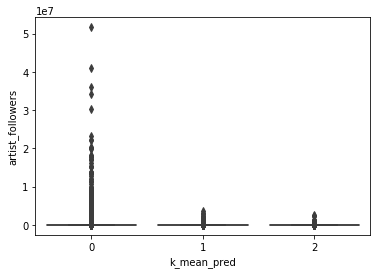

In [69]:
sns.boxplot(x="k_mean_pred", y="artist_followers", data=X_train_joined)

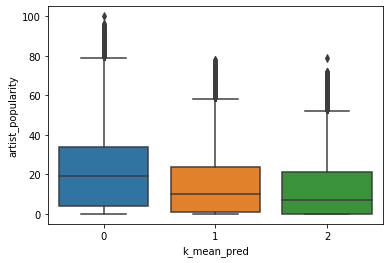

In [70]:
sns.boxplot(x="k_mean_pred", y="artist_popularity", data=X_train_joined)

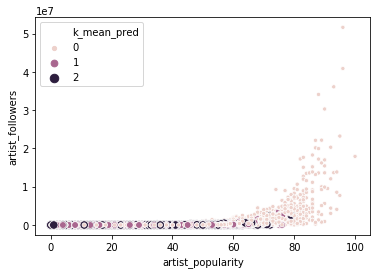

In [101]:
sns.scatterplot(x="artist_popularity", y="artist_followers", hue="k_mean_pred", size="k_mean_pred", data=X_train_joined)


**Track Popularity**

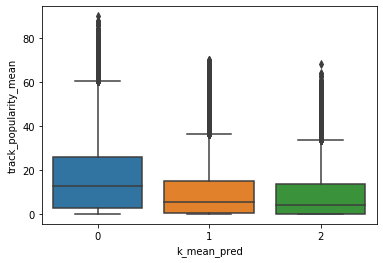

In [71]:
sns.boxplot(x="k_mean_pred", y="track_popularity_mean", data=X_train_joined)

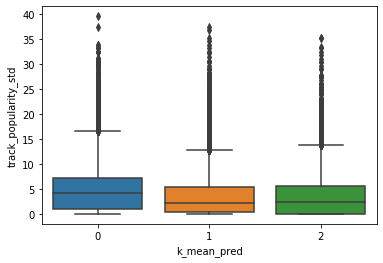

In [72]:
sns.boxplot(x="k_mean_pred", y="track_popularity_std", data=X_train_joined)

**Track Release Year**

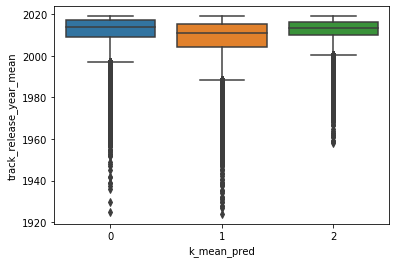

In [73]:
sns.boxplot(x="k_mean_pred", y="track_release_year_mean", data=X_train_joined)

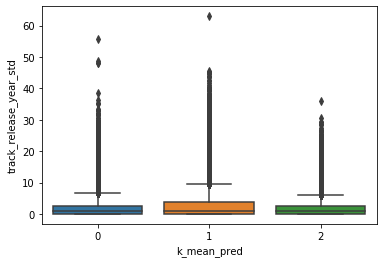

In [74]:
sns.boxplot(x="k_mean_pred", y="track_release_year_std", data=X_train_joined)

**Acousticness**

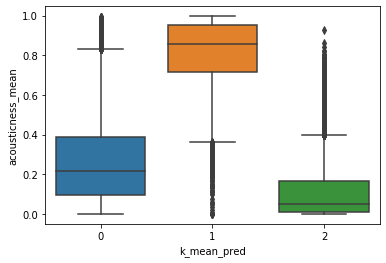

In [75]:
sns.boxplot(x="k_mean_pred", y="acousticness_mean", data=X_train_joined)

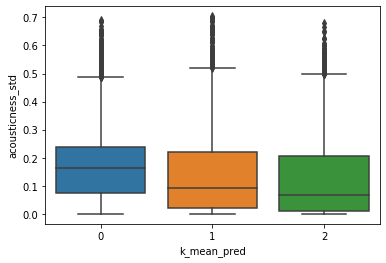

In [76]:
sns.boxplot(x="k_mean_pred", y="acousticness_std", data=X_train_joined)

**Danceability**

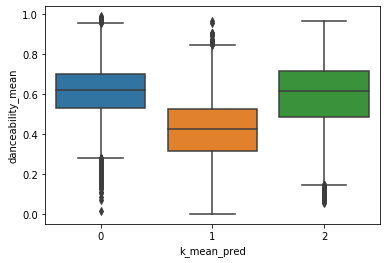

In [77]:
sns.boxplot(x="k_mean_pred", y="danceability_mean", data=X_train_joined)

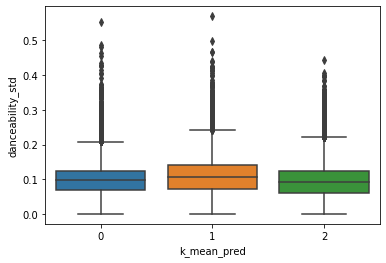

In [78]:
sns.boxplot(x="k_mean_pred", y="danceability_std", data=X_train_joined)

**Duration**

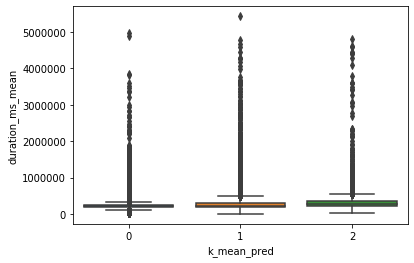

In [79]:
sns.boxplot(x="k_mean_pred", y="duration_ms_mean", data=X_train_joined)

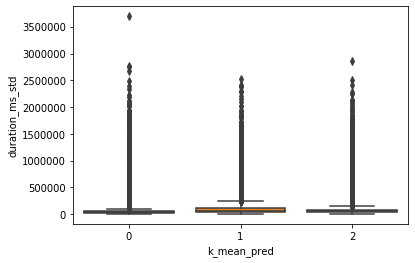

In [80]:
sns.boxplot(x="k_mean_pred", y="duration_ms_std", data=X_train_joined)

**Energy**

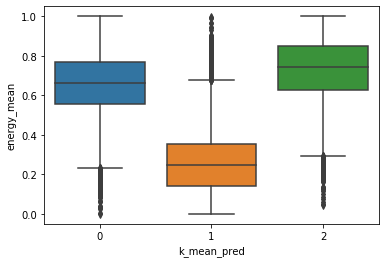

In [81]:
sns.boxplot(x="k_mean_pred", y="energy_mean", data=X_train_joined)

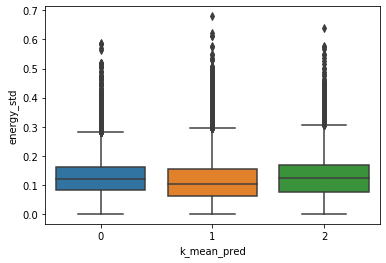

In [82]:
sns.boxplot(x="k_mean_pred", y="energy_std", data=X_train_joined)

**Instrumentalness**

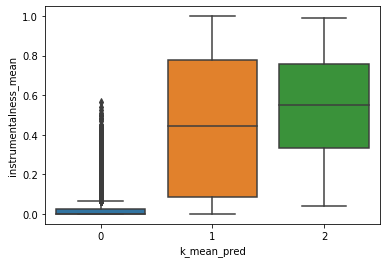

In [83]:
sns.boxplot(x="k_mean_pred", y="instrumentalness_mean", data=X_train_joined)

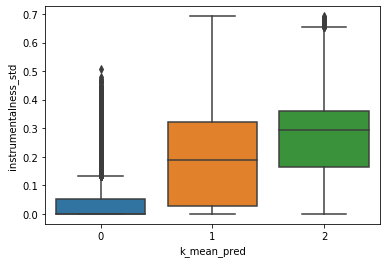

In [84]:
sns.boxplot(x="k_mean_pred", y="instrumentalness_std", data=X_train_joined)

**Liveness**

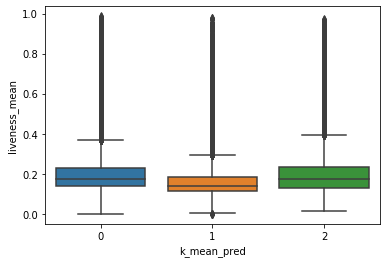

In [85]:
sns.boxplot(x="k_mean_pred", y="liveness_mean", data=X_train_joined)

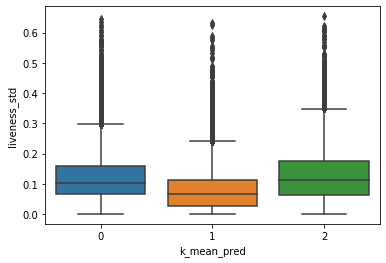

In [86]:
sns.boxplot(x="k_mean_pred", y="liveness_std", data=X_train_joined)

**Loudness**

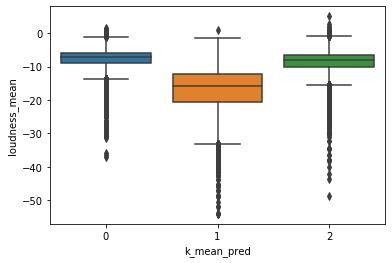

In [87]:
sns.boxplot(x="k_mean_pred", y="loudness_mean", data=X_train_joined)

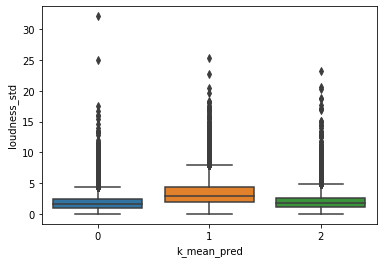

In [88]:
sns.boxplot(x="k_mean_pred", y="loudness_std", data=X_train_joined)

**Speechiness**

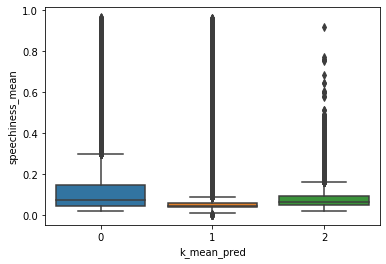

In [89]:
sns.boxplot(x="k_mean_pred", y="speechiness_mean", data=X_train_joined)

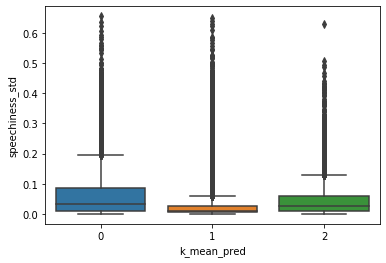

In [90]:
sns.boxplot(x="k_mean_pred", y="speechiness_std", data=X_train_joined)

**Tempo**

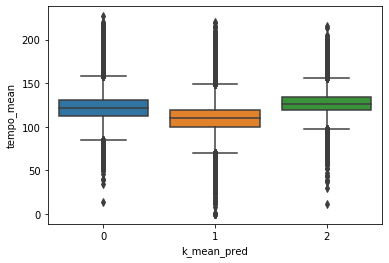

In [91]:
sns.boxplot(x="k_mean_pred", y="tempo_mean", data=X_train_joined)

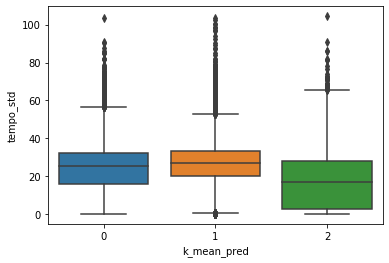

In [92]:
sns.boxplot(x="k_mean_pred", y="tempo_std", data=X_train_joined)

**Valence**

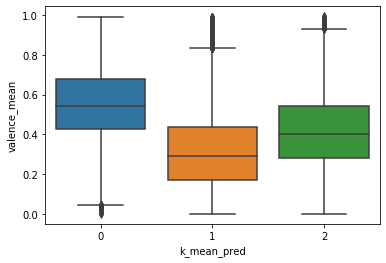

In [93]:
sns.boxplot(x="k_mean_pred", y="valence_mean", data=X_train_joined)

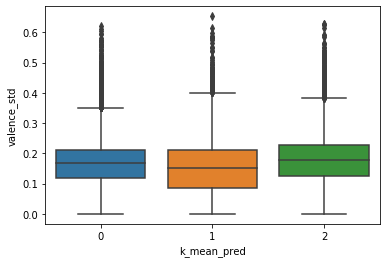

In [94]:
sns.boxplot(x="k_mean_pred", y="valence_std", data=X_train_joined)